In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical


In [2]:
# Load dataset
df = pd.read_csv('Urban Sound Dataset.csv')
print(df.head())

   ID         Class
0   0         siren
1   1  street_music
2   2      drilling
3   3         siren
4   4      dog_bark


In [3]:
# Feature extraction function
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        padded_mfccs = np.pad(mfccs, ((0, 0), (0, max(0, max_pad_len - mfccs.shape[1]))), mode='constant')
        return padded_mfccs[:, :max_pad_len]  # Ensure fixed size
    except Exception as e:
        print(f"Error encountered while parsing file {file_path}: {e}")
        return None

In [4]:

# Extract features and labels
features = []
labels = []

for idx, row in df.iterrows():
    file_path = os.path.join('Train', f"{row['ID']}.wav")
    mfccs = extract_features(file_path)
    if mfccs is not None:
        features.append(mfccs)
        labels.append(row['Class'])

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [5]:
# Convert to arrays
features = np.array(features)
labels = np.array(labels)

In [6]:
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded) #one hot encoding

In [7]:
# Reshape features for CNN input
features = features[..., np.newaxis]  # Add channel dimension


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)


In [9]:

# Build CNN model
model = Sequential()

In [10]:
# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(40, 174, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(labels_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - accuracy: 0.2289 - loss: 3.8339 - val_accuracy: 0.3931 - val_loss: 1.6402
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.4283 - loss: 1.5653 - val_accuracy: 0.5414 - val_loss: 1.4118
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.5306 - loss: 1.2995 - val_accuracy: 0.6069 - val_loss: 1.2293
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.6215 - loss: 1.0421 - val_accuracy: 0.6667 - val_loss: 1.1530
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.6604 - loss: 0.9608 - val_accuracy: 0.6575 - val_loss: 1.1383
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.7193 - loss: 0.8089 - val_accuracy: 0.7517 - val_loss: 0.8722
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.7790 - loss: 0.6922 - val_accuracy: 0.7414 - val_loss: 0.9044
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.7771 - loss: 0

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8688 - loss: 0.6772
Test Loss: 0.5328665375709534, Test Accuracy: 0.8877645134925842


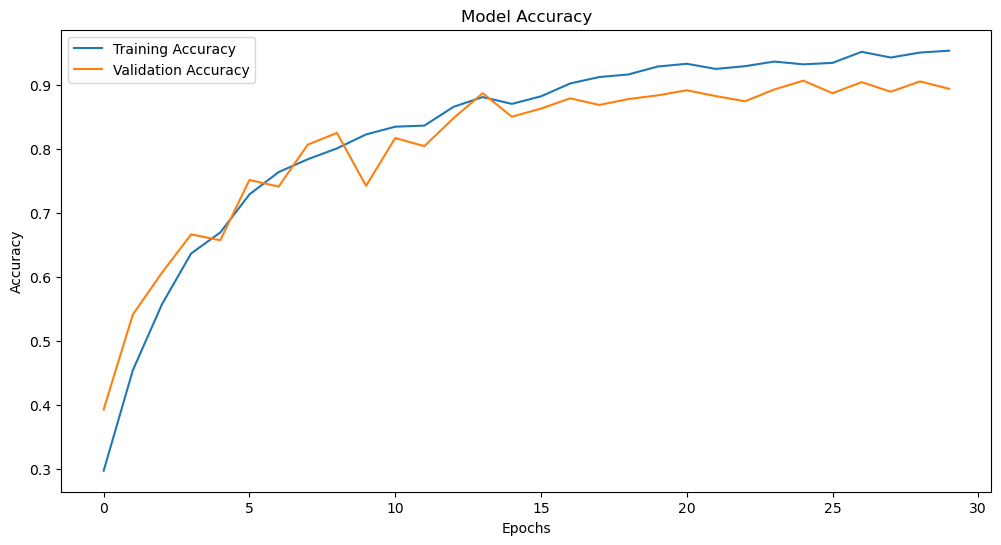

In [13]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

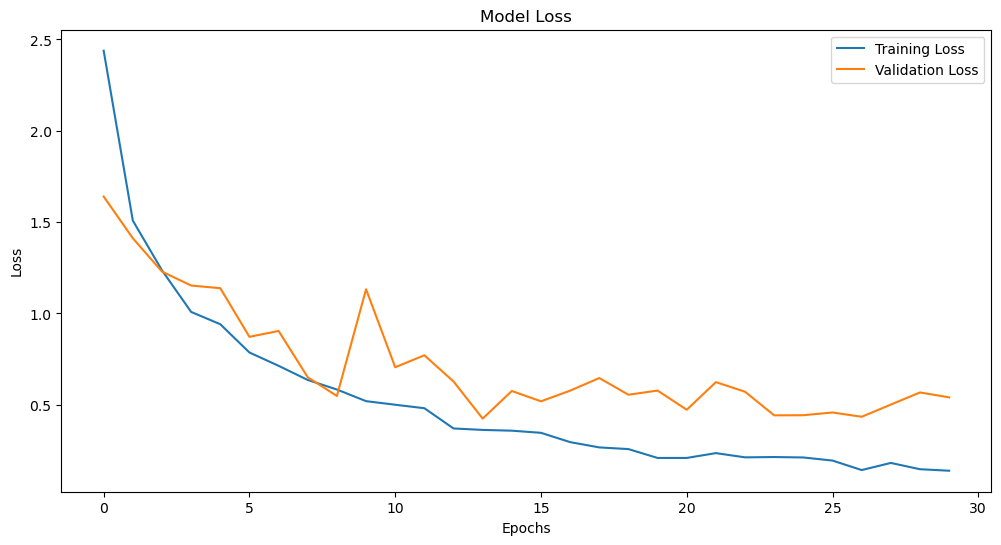

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8688 - loss: 0.6772
Test Loss: 0.5328665375709534
Test Accuracy: 0.8877645134925842


In [16]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True class indices
y_true_classes = np.argmax(y_test, axis=1)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [17]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
print("Classification Report:")
print(report)


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.93      0.98      0.95       133
        car_horn       0.93      0.88      0.90        48
children_playing       0.72      0.76      0.74       107
        dog_bark       0.83      0.88      0.85       117
        drilling       0.90      0.90      0.90       133
   engine_idling       0.86      0.95      0.91       130
        gun_shot       0.95      0.93      0.94        40
      jackhammer       0.95      0.99      0.97       145
           siren       0.98      0.85      0.91       112
    street_music       0.90      0.74      0.81       122

        accuracy                           0.89      1087
       macro avg       0.89      0.88      0.89      1087
    weighted avg       0.89      0.89      0.89      1087



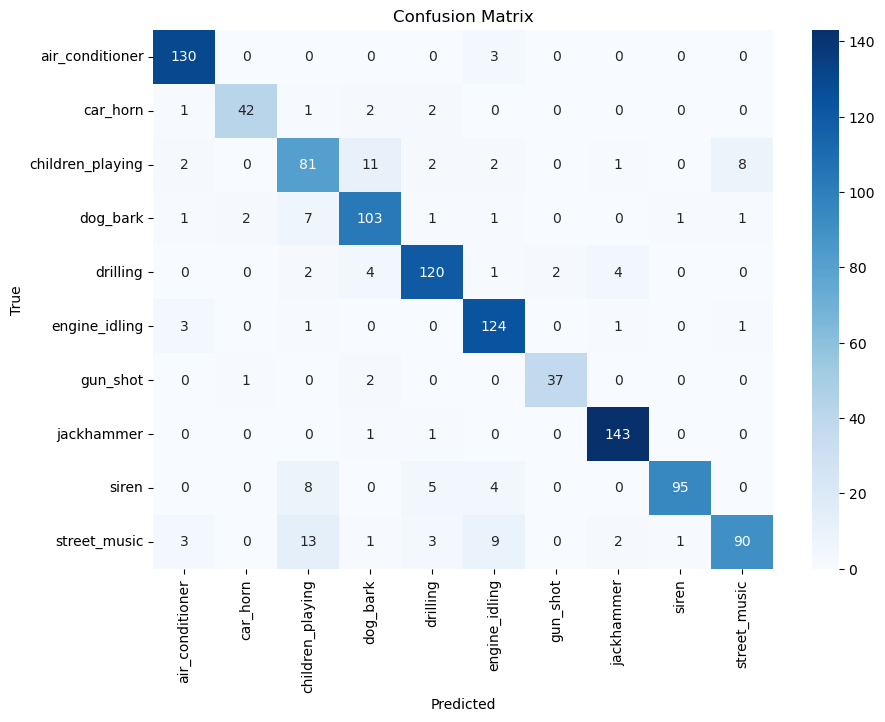

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [21]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

# Define a custom metric for top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# Compute top-3 accuracy
print(f"Top-3 Accuracy: {top_3_accuracy(y_test, y_pred_probs).numpy()}")


Top-3 Accuracy: [1. 1. 1. ... 1. 1. 1.]


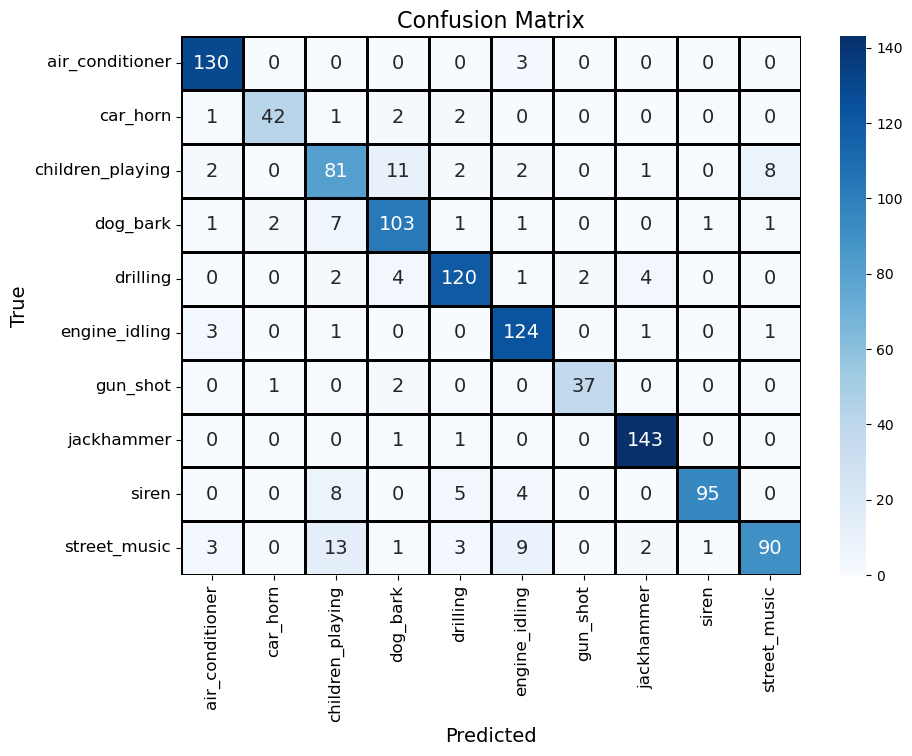

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with larger font size for annotations
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 14}, linewidths=1, linecolor='black')

plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
